In [1]:
!rm -rf torch_utils
!rm -rf models
!git clone https://github.com/twm105/torch_utils
!git clone https://github.com/twm105/models

import sys
sys.path.append('/content/torch_utils') # colab requires utils to be added to the path for relative imports
sys.path.append('/content/models')

Cloning into 'torch_utils'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 126 (delta 79), reused 83 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (126/126), 39.33 KiB | 1.57 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Cloning into 'models'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 82 (delta 39), reused 65 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 27.18 MiB | 36.48 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import v2, InterpolationMode
from torchvision.datasets import CIFAR100, CIFAR10
from torch.utils.data import DataLoader, default_collate
try:
  from timm.data.auto_augment import rand_augment_transform
except:
  print("[INFO] Couldn't find timm... installing it.")
  !pip install -q timm
  from timm.data.auto_augment import rand_augment_transform
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [3]:
from models.vit import ViT
from models.convit import ConViT
from models.cct import CCT
from torch_utils import engine
from torch_utils.helper_functions import set_seeds, plot_loss_curves, show_batch_images
from datetime import datetime, timezone

In [4]:
# set up image transforms including augmentation
img_size = (32, 32)
cifar10_means = [0.4914, 0.4822, 0.4465]
cifar10_stds = [0.2470, 0.2435, 0.2616]
set_seeds()

resize_transform = v2.Compose([
    v2.Resize(size=img_size),
])

# augmentations_transform = v2.Compose([
#     v2.TrivialAugmentWide(num_magnitude_bins=31),
# ])

augmentation_transform = v2.Compose([
    v2.ToPILImage(),
    rand_augment_transform(config_str='rand-m9-mstd0.5-inc1', hparams={}),
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.RandomErasing(0.25), # not in the original CCT-7/3x1 recipe
])

normalise_transform = v2.Compose([
    v2.Normalize(
        mean=cifar10_means,
        std=cifar10_stds,
    )
])

train_transforms = v2.Compose([
    resize_transform,
    augmentation_transform,
    normalise_transform,
])

test_transforms = v2.Compose([
    resize_transform,
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    normalise_transform,
])

In [5]:
# get training data
DATASET = CIFAR10
train_data = DATASET(root='data/',
                     download=True,
                     train=True,
                     transform=train_transforms,)
test_data = DATASET(root='data/',
                    download=True,
                    train=False,
                    transform=test_transforms)

train_data[0]

100%|██████████| 170M/170M [00:02<00:00, 82.6MB/s]


(Image([[[ 0.5667,  0.3127,  0.4238,  ...,  0.5191,  0.4238,  0.3603],
         [-0.1160, -0.3700, -0.0843,  ...,  1.5828,  1.5193,  1.5669],
         [ 0.0269, -0.1160,  0.4079,  ...,  1.5034,  1.5352,  1.3605],
         ...,
         [ 1.3129,  1.2018,  1.1541,  ...,  0.5508,  0.5191,  0.4714],
         [ 0.8683,  0.7572,  0.9636,  ...,  0.9319,  1.1700,  0.9477],
         [ 0.8207,  0.6778,  0.8525,  ...,  1.4399,  0.4079,  1.5828]],
 
        [[ 0.6609,  0.4033,  0.4355,  ...,  0.1456,  1.6755,  1.6594],
         [-0.0155, -0.3376, -0.2087,  ...,  1.0797,  0.9991,  1.0636],
         [ 0.0489, -0.2248,  0.0973,  ...,  1.0152,  1.0152,  0.8381],
         ...,
         [ 0.7576,  0.4838,  0.6126,  ...,  0.1617,  0.1617,  0.2100],
         [ 0.2583,  1.6433,  0.3388,  ...,  0.4033,  0.6609,  0.5160],
         [ 0.3388,  0.0973,  0.3066,  ...,  0.9830,  1.5628,  1.1441]],
 
        [[ 0.7667,  0.4968,  0.4668,  ...,  1.4412,  1.3513,  1.3663],
         [ 0.1221, -0.1778, -0.1778,  ..., 

In [6]:
# check number of classes to predict
# classes = []
# classes = set([cl[1] for cl in train_data])

# num_classes = len(classes)
num_classes = 10
print(f"Dataset contains {num_classes} classes.")

Dataset contains 10 classes.


In [7]:
# create dataloaders
import os
NUM_WORKERS = os.cpu_count()
BATCH_SCALE = 1
BATCH_SIZE = int(128 * BATCH_SCALE)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# define batchwise_transforms to apply to collate function, then apply to second train_dataloader
mixup = v2.MixUp(alpha=0.8,
                  num_classes=num_classes,)
cutmix = v2.CutMix(alpha=1.0,
                    num_classes=num_classes,)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup], [0.5, 0.5])

def collate_fn(batch):
  return cutmix_or_mixup(*default_collate(batch))

train_dataloader_cutmix_mixup = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn,
)

print(f"Train batches per epoch: {len(train_dataloader)}")
print(f"Test batches per epoch: {len(test_dataloader)}")

Train batches per epoch: 391
Test batches per epoch: 79


In [8]:
X0, y0 = next(iter(train_dataloader_cutmix_mixup))
len(y0.shape)

2

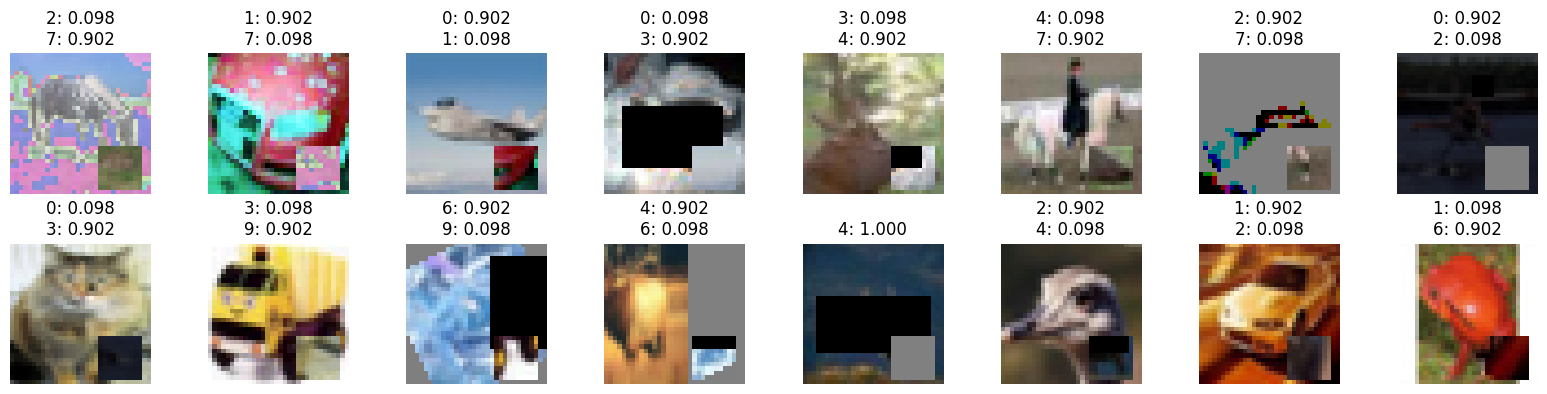

In [9]:
# plot sample of images from dataloader
show_batch_images(batch=(X0, y0),
                  n_images=16,
                  unnormalise={"mean": cifar10_means, "std": cifar10_stds})

In [10]:
# build cct model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# initiate CCT model
cct = CCT(pool_kernel=3,
          pool_stride=2,
          pool_padding=1,
          num_cnn_layers=1,
          num_vit_layers=7,
          pos_embed_type="learnable",)

# summarise model
img0, label0 = next(iter(train_dataloader))
summary(model=cct,
        input_size=img0.shape,
        col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
CCT                                           [128, 3, 32, 32]          [128, 10]                 --                        True
├─Sequential: 1-1                             [128, 3, 32, 32]          [128, 256, 256]           --                        True
│    └─Tokenizer: 2-1                         [128, 3, 32, 32]          [128, 256, 16, 16]        --                        True
│    │    └─Sequential: 3-1                   [128, 3, 32, 32]          [128, 256, 16, 16]        7,168                     True
│    └─Flatten: 2-2                           [128, 256, 16, 16]        [128, 256, 256]           --                        --
│    └─Dropout: 2-3                           [128, 256, 256]           [128, 256, 256]           --                        --
├─LearnablePositionEmbeddings: 1-2            [128, 256, 256]           [128, 256, 256]         

In [11]:
# set up running results dict
result_fields = ['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc', 'lr', 'weight_decay', 'task', ]
results = {k: [] for k in result_fields}
results

{'epoch': [],
 'train_loss': [],
 'train_acc': [],
 'test_loss': [],
 'test_acc': [],
 'lr': [],
 'weight_decay': [],
 'task': []}

In [12]:
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

[INFO] Run: 250505z0953-cct-7_3x1-AllMixupRE
[INFO] Training with batch size 128 and LR 0.00055
[INFO] Created SummaryWriter, saving to: runs/250505z0953/250505z0953-cct-7_3x1-AllMixupRE...
[INFO] Compiling model...
[INFO] Model compiled.


Training Run:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 001 | train_loss: 2.2694 | train_acc: 0.1610 | test_loss: 2.0442 | test_acc: 0.3000 | lr: 1.00e-05 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 002 | train_loss: 2.2171 | train_acc: 0.2020 | test_loss: 1.8999 | test_acc: 0.3659 | lr: 6.40e-05 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 003 | train_loss: 2.1866 | train_acc: 0.2217 | test_loss: 1.8727 | test_acc: 0.3751 | lr: 1.18e-04 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 004 | train_loss: 2.1629 | train_acc: 0.2405 | test_loss: 1.7757 | test_acc: 0.4300 | lr: 1.72e-04 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 005 | train_loss: 2.1301 | train_acc: 0.2646 | test_loss: 1.7097 | test_acc: 0.4572 | lr: 2.26e-04 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 006 | train_loss: 2.0995 | train_acc: 0.2861 | test_loss: 1.6280 | test_acc: 0.5019 | lr: 2.80e-04 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 007 | train_loss: 2.0743 | train_acc: 0.3047 | test_loss: 1.6105 | test_acc: 0.4852 | lr: 3.34e-04 | weight_dec

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 010 | train_loss: 2.0187 | train_acc: 0.3469 | test_loss: 1.5180 | test_acc: 0.5719 | lr: 4.96e-04 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 011 | train_loss: 1.9967 | train_acc: 0.3584 | test_loss: 1.4208 | test_acc: 0.5917 | lr: 5.50e-04 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 012 | train_loss: 1.9767 | train_acc: 0.3700 | test_loss: 1.4311 | test_acc: 0.5958 | lr: 5.50e-04 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 013 | train_loss: 1.9758 | train_acc: 0.3725 | test_loss: 1.4382 | test_acc: 0.5884 | lr: 5.50e-04 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 014 | train_loss: 1.9691 | train_acc: 0.3800 | test_loss: 1.3942 | test_acc: 0.6212 | lr: 5.50e-04 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 015 | train_loss: 1.9427 | train_acc: 0.3957 | test_loss: 1.3430 | test_acc: 0.6442 | lr: 5.50e-04 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 016 | train_loss: 1.9368 | train_acc: 0.4016 | test_loss: 1.3886 | test_acc: 0.6330 | lr: 5.50e-04 | weight_dec

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 290 | train_loss: 1.2706 | train_acc: 0.7952 | test_loss: 0.6547 | test_acc: 0.9432 | lr: 1.00e-05 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 291 | train_loss: 1.2895 | train_acc: 0.7888 | test_loss: 0.6573 | test_acc: 0.9424 | lr: 1.00e-05 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 292 | train_loss: 1.2826 | train_acc: 0.7849 | test_loss: 0.6554 | test_acc: 0.9431 | lr: 1.00e-05 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 293 | train_loss: 1.2905 | train_acc: 0.7765 | test_loss: 0.6552 | test_acc: 0.9439 | lr: 1.00e-05 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 294 | train_loss: 1.2980 | train_acc: 0.7798 | test_loss: 0.6564 | test_acc: 0.9425 | lr: 1.00e-05 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 295 | train_loss: 1.3100 | train_acc: 0.7752 | test_loss: 0.6608 | test_acc: 0.9415 | lr: 1.00e-05 | weight_decay: 6.00e-02 | task: CIFAR10
Epoch: 296 | train_loss: 1.2866 | train_acc: 0.7861 | test_loss: 0.6575 | test_acc: 0.9442 | lr: 1.00e-05 | weight_dec

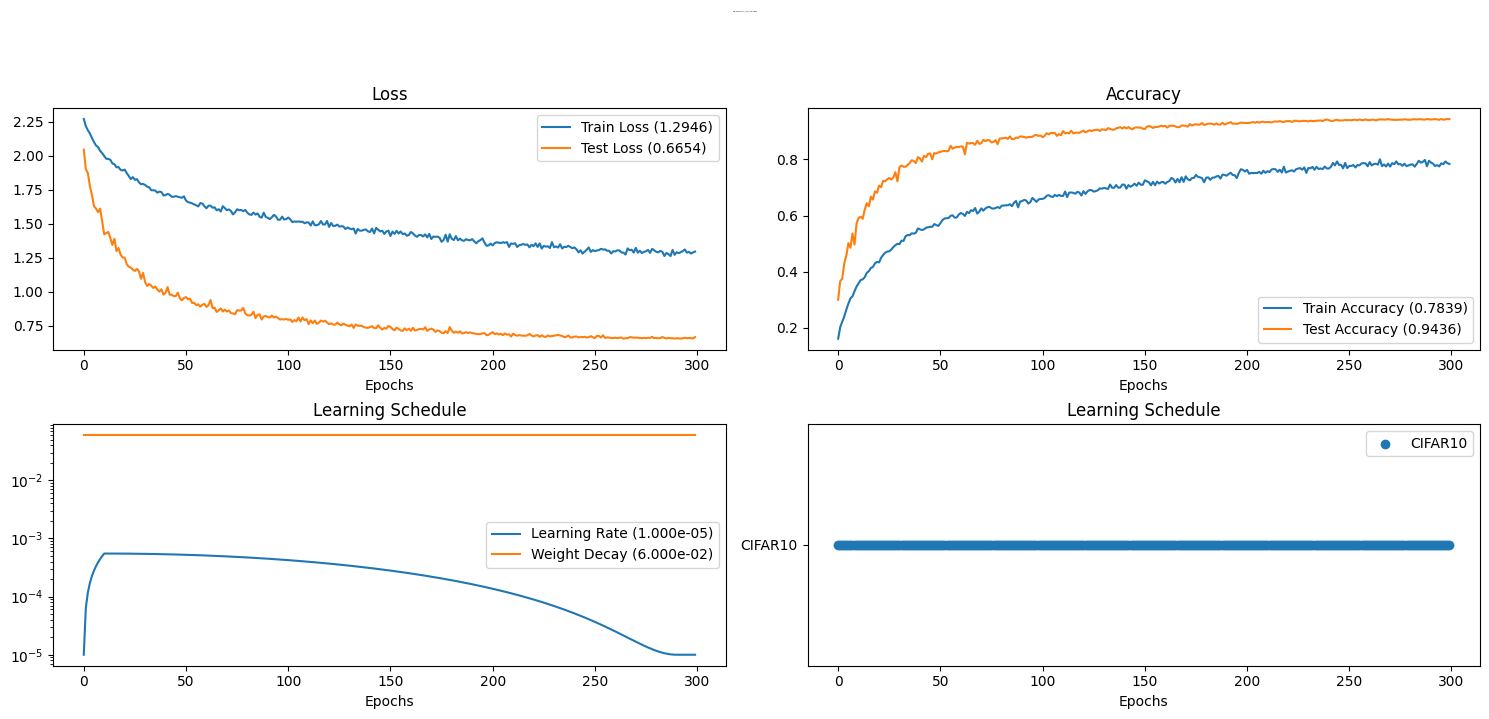

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# clear GPU model from VRAM if desired
if False:
  import gc
  del model
  gc.collect()                # Clear Python references
  torch.cuda.empty_cache()    # Release cached memory held by PyTorch

# set path for checkpointing
TRAINED_MODEL_SAVE_PATH = "models/trained_models"

# load from checkpoint if required
if False:
  checkpoint_filename = ''
  checkpoint = checkpoint.load_state_dict(torch.load(os.path.join(TRAINED_MODEL_SAVE_PATH, checkpoint_filename)))
  results = checkpoint["results"]
  writer = checpoint["writer"]
  optimizer = checkpoint["optimizer"]
  scheduler = checkpoint["scheduler"]

# build model and set save name if required
if len(results["epoch"]) == 0:
  model = CCT(kernel_size=3,
              pool_kernel=3,
              pool_stride=2,
              pool_padding=1,
              num_cnn_layers=1,
              num_vit_layers=7,
              pos_embed_type="learnable",)

  CHECKPOINT_INTERVAL = 50
  timestamp = datetime.now(timezone.utc).strftime(r"%y%m%dz%H%M") # returns current datetime in YYMMDDzHHMM format
  MODEL_SAVE_BASE_NAME = timestamp + "-cct-7_3x1-AllMixupRE"
  print(f"[INFO] Run: {MODEL_SAVE_BASE_NAME}")

TASK = "CIFAR10"

# set learning schedule
LR_WARMUP = 1e-5 * BATCH_SCALE
LR = 55e-5 * BATCH_SCALE
MIN_LR = 1e-5 * BATCH_SCALE
print(f"[INFO] Training with batch size {BATCH_SIZE} and LR {LR}")

WEIGHT_DECAY = 6e-2

TOTAL_EPOCHS = 300
EPOCHS = TOTAL_EPOCHS - len(results["epoch"])
WARMUP_EPOCHS = 10
COOLDOWN_EPOCHS = 10
END_COSINE_ANNEALING = TOTAL_EPOCHS - WARMUP_EPOCHS - COOLDOWN_EPOCHS
ETA_MIN_COSINE_ANNEALING = MIN_LR

MIXUP_CUTMIX_OFF = max(int(TOTAL_EPOCHS * (300/300)) - (TOTAL_EPOCHS - EPOCHS), 0) # accounts for resuming
LABEL_SMOOTHING = 0.1

if True:
  if len(results["epoch"]) == 0:
    # initialise SummaryWriter for experiment
    writer = engine.create_writer(model_name=MODEL_SAVE_BASE_NAME)

    # initialise new optimizer, scheduler, loss_fn for each run (keep old ones if extending run)
    optimizer = torch.optim.AdamW(params=model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=WEIGHT_DECAY,
                                  fused=True, # free speed
                                  )

    scheduler_warmup = torch.optim.lr_scheduler.LinearLR(optimizer,
                                                        start_factor=LR_WARMUP/LR,
                                                        total_iters=WARMUP_EPOCHS)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                                  T_max=END_COSINE_ANNEALING,
                                                                  eta_min=ETA_MIN_COSINE_ANNEALING,)
    scheduler_constant = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=MIN_LR / LR, total_iters=COOLDOWN_EPOCHS)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer,
                                                      schedulers=[scheduler_warmup, scheduler_cosine, scheduler_constant],
                                                      milestones=[WARMUP_EPOCHS, WARMUP_EPOCHS + END_COSINE_ANNEALING])
    loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

  # define kwargs to pass to training (up to cutmix switch off)
  mixup_cutmix_train_config = dict(
      model=model,
      train_dataloader=train_dataloader_cutmix_mixup,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=MIXUP_CUTMIX_OFF,
      device=device,
      scheduler=scheduler,
      # batchwise_transform=batchwise_transform,
      # batchwise_transform_on_off=batchwise_transform_on_off,
      results=results,
      task=TASK,
      # stop_training=engine.early_stopping_ratio,
      writer=writer,
      checkpoint_interval=CHECKPOINT_INTERVAL,
      save_final_model=True,
      model_save_path=TRAINED_MODEL_SAVE_PATH,
      model_save_base_name=MODEL_SAVE_BASE_NAME,
      colab_local_path="/content/ckpts",
  )

  # run training run (with cutmix_mixup on) if required
  if MIXUP_CUTMIX_OFF > 0:
    results = engine.train(**mixup_cutmix_train_config)

  # config update with mixup or cutmix removed from dataloader if required
  if (EPOCHS - MIXUP_CUTMIX_OFF) > 0:
    standard_train_config = mixup_cutmix_train_config
    standard_train_config['train_dataloader'] = train_dataloader
    standard_train_config['epochs'] = EPOCHS - MIXUP_CUTMIX_OFF
    standard_train_config['torch_compile'] = False # model is already compiled
    standard_train_config['results'] = results

    # run training run (with cutmix_mixup off)
    results = engine.train(**standard_train_config)

  # save training metadata to model
  model.results = results

  # plot loss curves for latest results
  plot_loss_curves(results, title=MODEL_SAVE_BASE_NAME)

In [15]:
from google.colab import drive
import os, shutil, pickle

# # 1. Mount Google Drive
# drive.mount('/content/drive')

# 2. Copy files starting with a prefix from first folder
src_dir = TRAINED_MODEL_SAVE_PATH
dst_dir = f"/content/drive/MyDrive/{TRAINED_MODEL_SAVE_PATH}"
prefix = MODEL_SAVE_BASE_NAME

os.makedirs(dst_dir, exist_ok=True)

for fname in os.listdir(src_dir):
    if fname.startswith(prefix) and "_final" in fname:
        shutil.copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

# 3. Copy entire second folder from another VM path
second_src = f"runs/{timestamp}"
second_dst = f"/content/drive/MyDrive/runs/{timestamp}"

shutil.copytree(second_src, second_dst, dirs_exist_ok=True)

# 4. Save results dictionary to Drive
with open(f"/content/drive/MyDrive/{prefix}_results.pkl", "wb") as f:
    pickle.dump(results, f)

# # 5. Optionally: disconnect runtime after saving
# from google.colab import runtime
# runtime.disconnect()

In [ ]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
%load_ext tensorboard
%tensorboard --logdir runs